<a href="https://colab.research.google.com/github/Zhang-Cheng-76200/Random-Walk-Prediction/blob/main/Simulated_random_walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

In [2]:
from google.colab import drive
drive.mount ('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


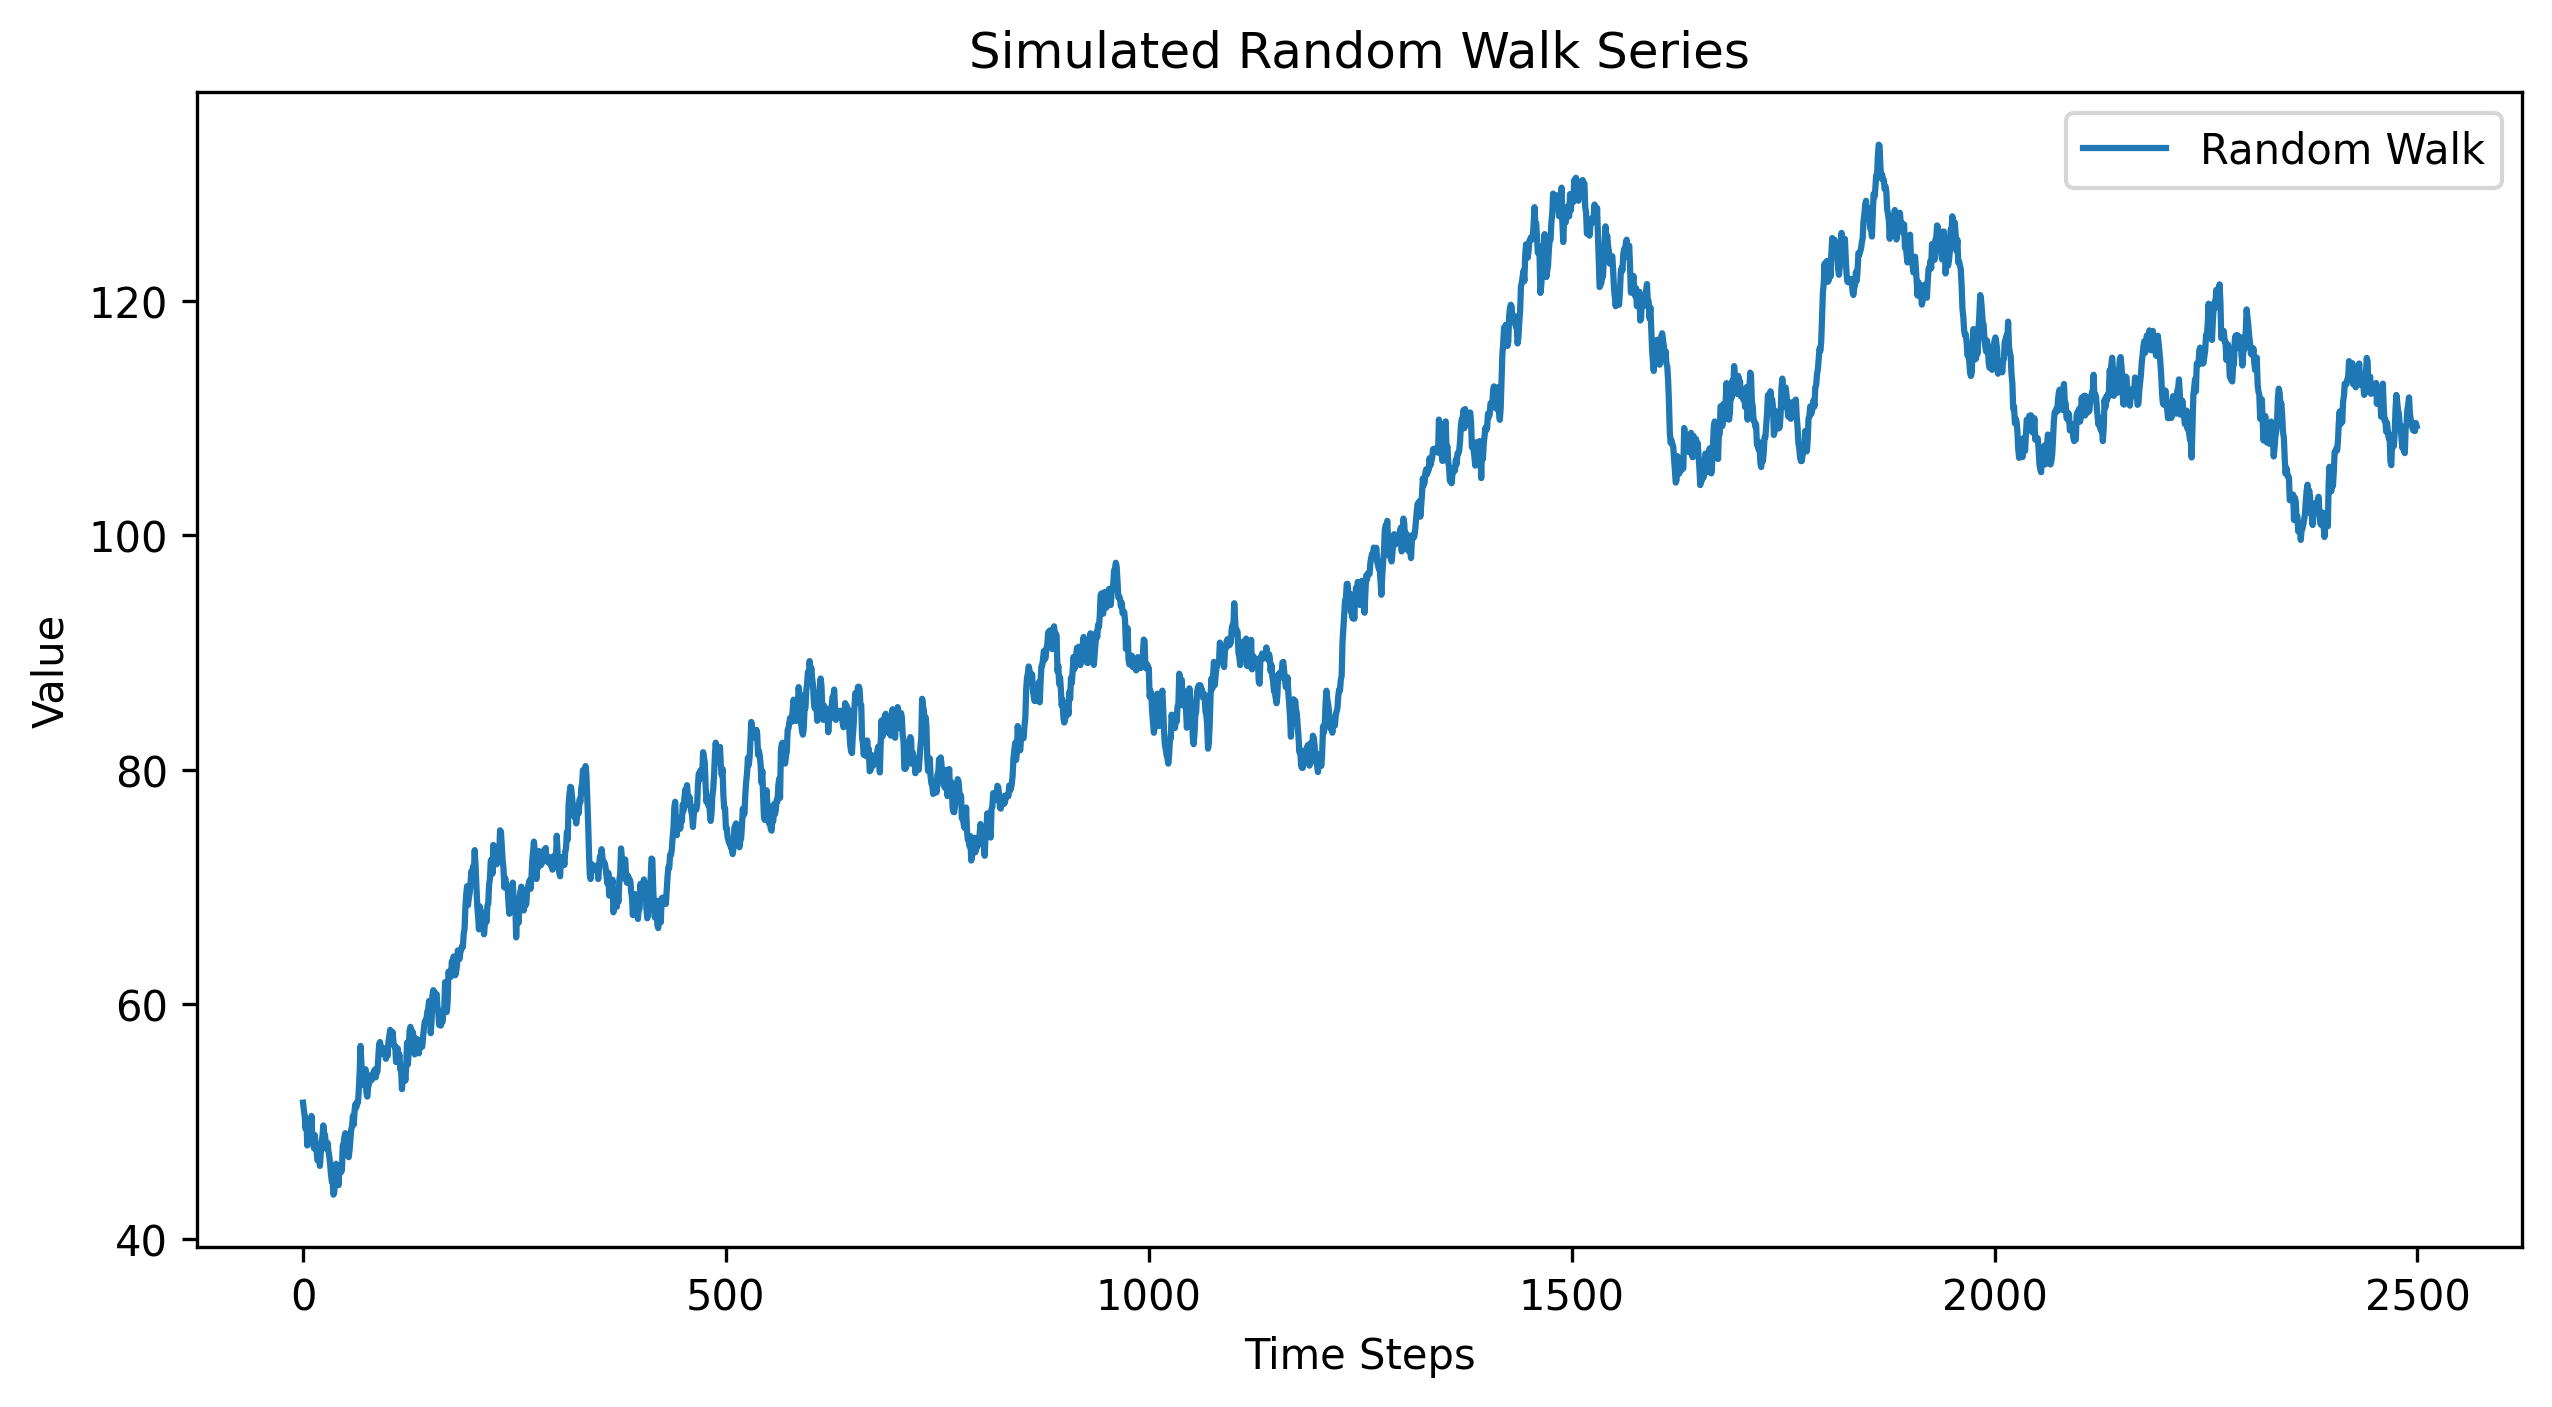

In [3]:
# Parameters
n_steps = 2500  # Number of steps in the random walk
initial_value = 50  # Initial positive value to ensure all steps remain positive
np.random.seed(1)  # Seed for reproducibility
train_size = 2300  # Size of the training set
# Simulate random walk data
steps = np.random.normal(0, 1, n_steps).cumsum()  # Generate normal steps
data = steps + initial_value  # Offset by the initial value to keep values positive

# Display the random walk series
plt.figure(figsize=(10, 5), dpi = 300)
plt.plot(data, label='Random Walk')
plt.title('Simulated Random Walk Series')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/Simulated_random_walk.tif")
plt.show()

In [4]:

# Split the data into train and test sets
train_data = data[:train_size]
test_data = data[train_size:]

# Generate naive forecast for the training set
naive_train = train_data[:-1]
y_train = train_data[1:]

# Calculate residuals in the training set
residuals_train = np.abs(y_train - naive_train)

# Calculate the mean of the residuals
mean_residual = np.mean(residuals_train)

# Generate naive forecast for the test set
naive_test = data[train_size-1:-1]
y_test = test_data

# Accuracy settings and trials
start_accuracy = 0.55
end_accuracy = 1.00
accuracy_step = 0.05
n_trials = 30
results = {}
# Calculate MAE and MSE for naive forecast
naive_mae = np.mean(np.abs(y_test - naive_test))
naive_mse = np.mean((y_test - naive_test)**2)

In [5]:
# Loop through different accuracies
for accuracy in np.arange(start_accuracy, end_accuracy + accuracy_step, accuracy_step):
    # Threshold and improvement calculations only once per accuracy level
    weight = 2 * accuracy - 1

    mad = np.mean(np.abs(residuals_train - weight * mean_residual))  # Using mean MAD across trials
    threshold_mae = weight * mean_residual / ((weight + 1) * mean_residual - mad)
    threshold_mse = (2 + weight) / 4
    improvement_mae = accuracy * ((weight + 1) * mean_residual - mad) - weight * mean_residual
    improvement_mse = (4 * weight * accuracy - weight**2 - 2 * weight) * mean_residual**2

    trial_results = []
    for trial in range(n_trials):
        # Generate movement predictions for the test set
        actual_movements_test = np.sign(np.diff(test_data, prepend=train_data[-1]))
        actual_movements_test = (actual_movements_test == 1).astype(int)
        predicted_movements = np.copy(actual_movements_test)

        # Randomly select indices based on accuracy without re-seeding
        mask = np.random.rand(len(test_data)) < accuracy
        incorrect_mask = ~mask
        predicted_movements[incorrect_mask] = 1 - predicted_movements[incorrect_mask]

        # Initialize fusion result array
        y_fusion = np.zeros_like(y_test)
        # Calculate fusion forecast
        for i in range(len(y_test)):
            y_fusion[i] = naive_test[i] + (weight * mean_residual if predicted_movements[i] == 1 else -weight * mean_residual)

        # Calculate MAE and MSE for fusion forecast
        mae_fusion = np.mean(np.abs(y_test - y_fusion))
        mse_fusion = np.mean((y_test - y_fusion)**2)

        # Store results for this trial
        trial_results.append({
            'predicted_movements': predicted_movements,
            'mae_fusion': mae_fusion,
            'mse_fusion': mse_fusion
        })

    # Store results and metrics for this accuracy
    results[accuracy] = {
        'trial_results': trial_results,
        'threshold_mae': threshold_mae,
        'threshold_mse': threshold_mse,
        'improvement_mae': improvement_mae,
        'improvement_mse': improvement_mse
    }

Naive Forecast - MAE: 0.821, MSE: 1.044
Statistical Summary of Fusion Forecast Performance:
Accuracy: 0.55
  MAE: 0.815 ± 0.006, Threshold ACC: 0.516
  MSE: 1.037 ± 0.012, Threshold ACC: 0.525
  Expected vs Actual Improvement MAE: 0.005 vs 0.005
  Expected vs Actual Improvement MSE: 0.006 vs 0.008
Accuracy: 0.60
  MAE: 0.804 ± 0.010, Threshold ACC: 0.532
  MSE: 1.022 ± 0.021, Threshold ACC: 0.550
  Expected vs Actual Improvement MAE: 0.020 vs 0.016
  Expected vs Actual Improvement MSE: 0.026 vs 0.022
Accuracy: 0.65
  MAE: 0.777 ± 0.017, Threshold ACC: 0.552
  MSE: 0.983 ± 0.037, Threshold ACC: 0.575
  Expected vs Actual Improvement MAE: 0.043 vs 0.043
  Expected vs Actual Improvement MSE: 0.058 vs 0.062
Accuracy: 0.70
  MAE: 0.742 ± 0.021, Threshold ACC: 0.572
  MSE: 0.939 ± 0.042, Threshold ACC: 0.600
  Expected vs Actual Improvement MAE: 0.072 vs 0.078
  Expected vs Actual Improvement MSE: 0.102 vs 0.105
Accuracy: 0.75
  MAE: 0.710 ± 0.024, Threshold ACC: 0.594
  MSE: 0.879 ± 0.043, 

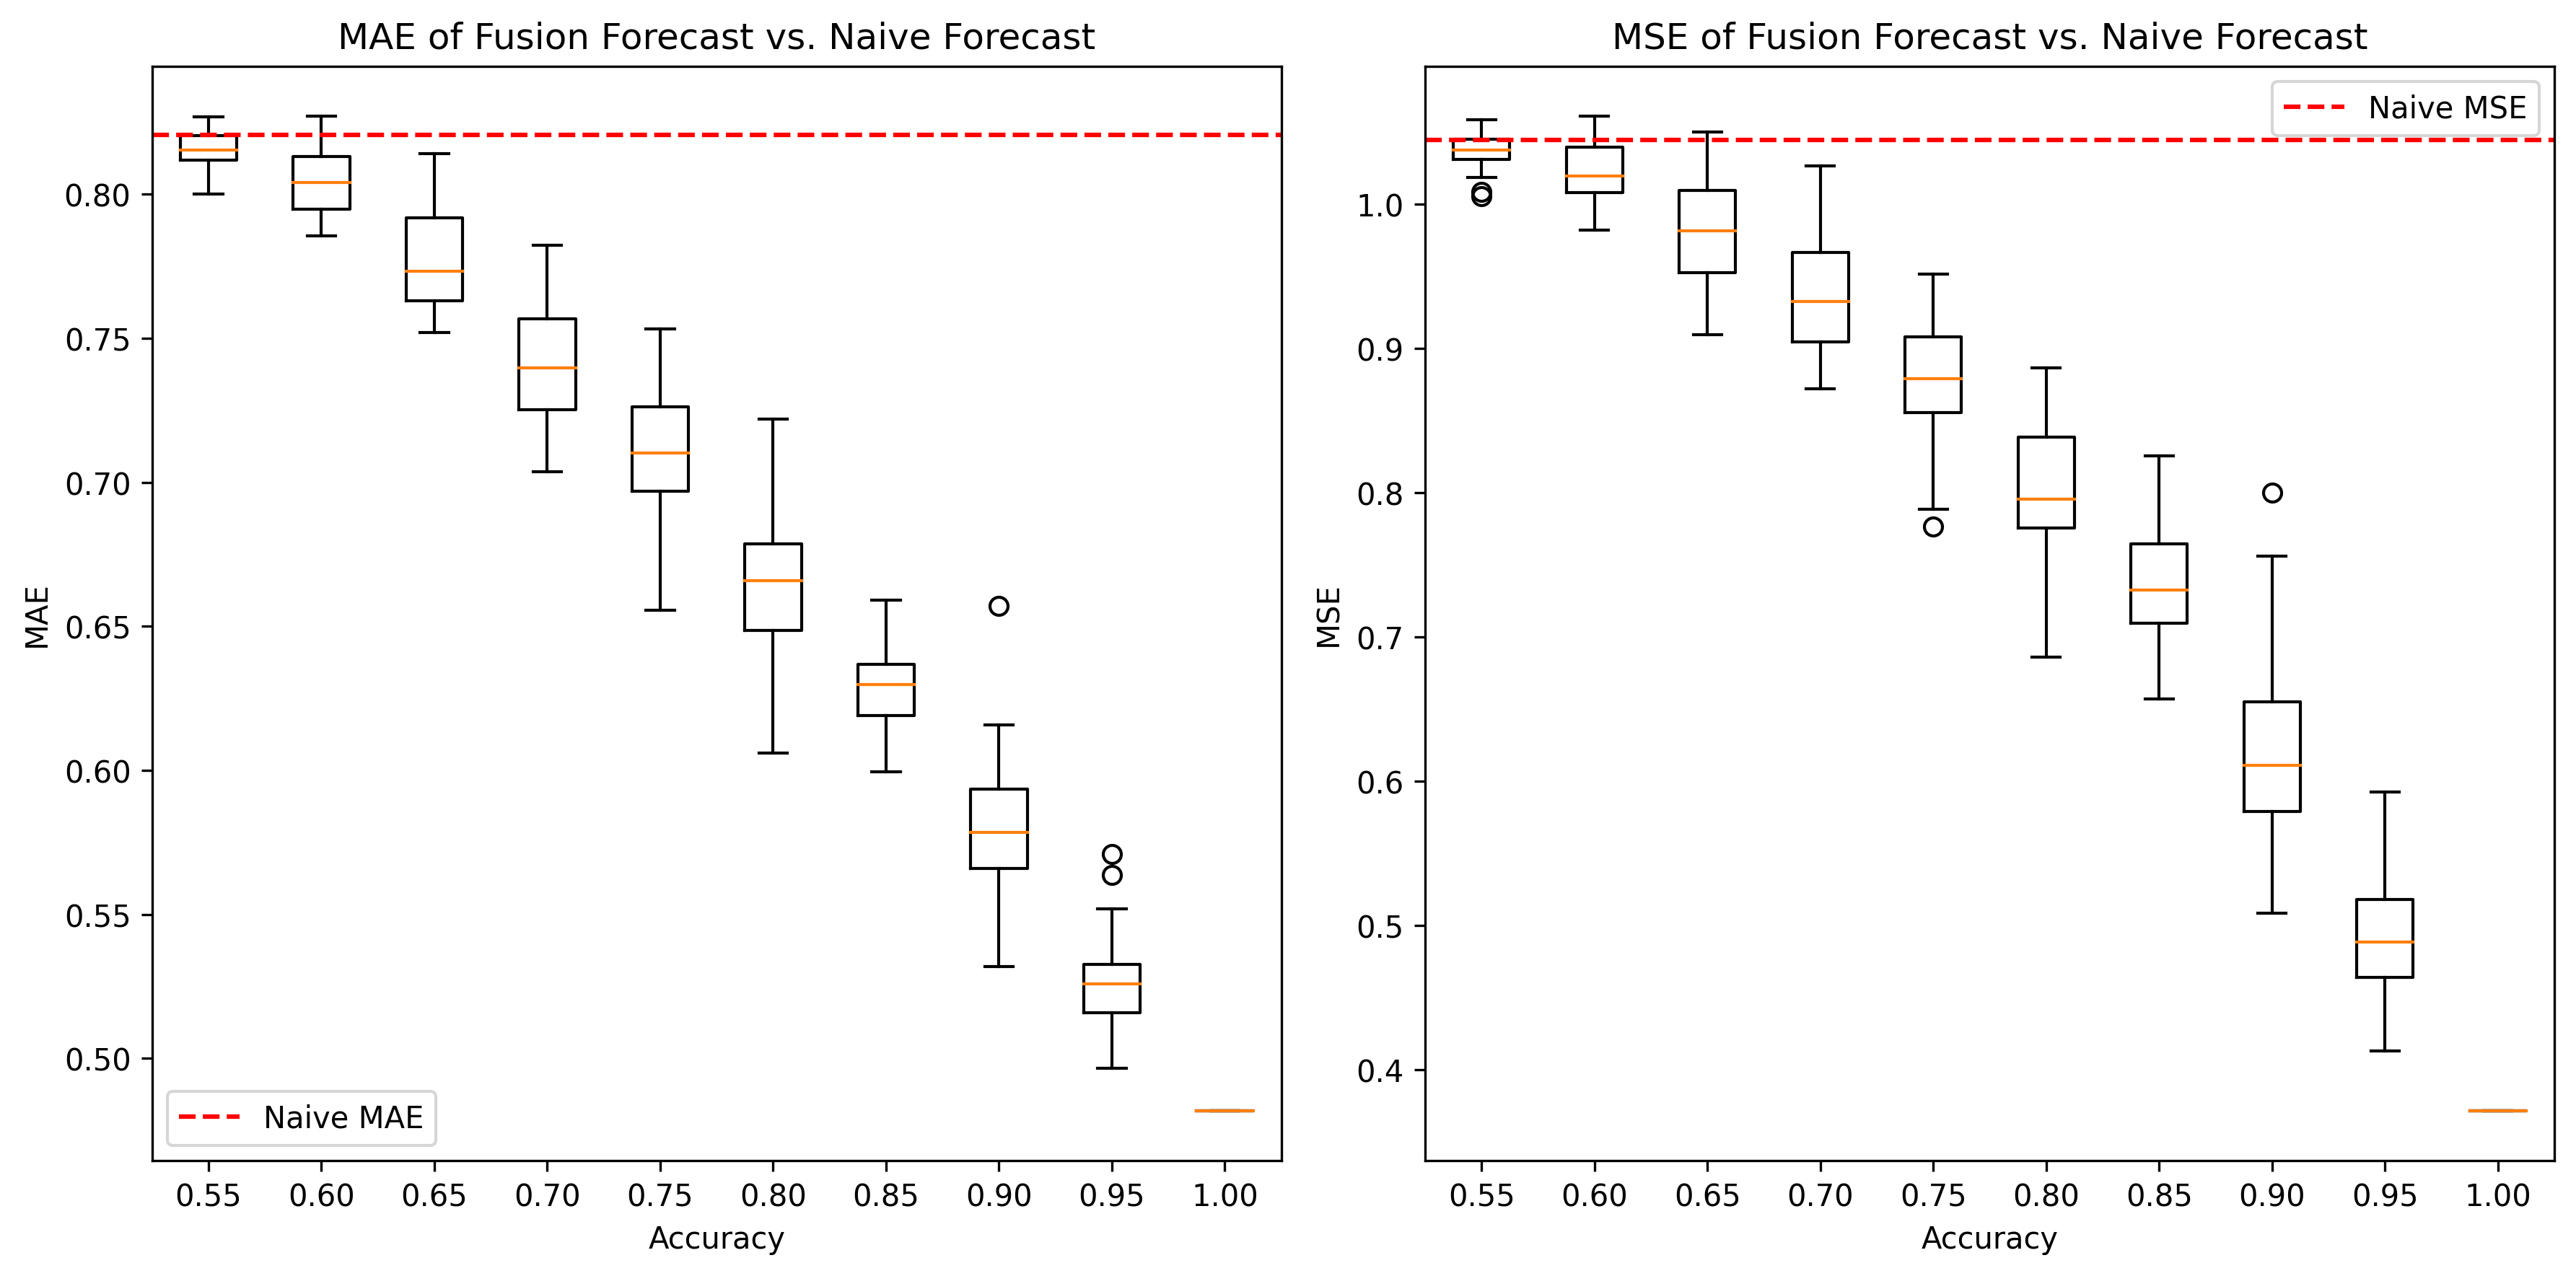

In [6]:
# Print MAE and MSE for naive forecast
print(f"Naive Forecast - MAE: {naive_mae:.3f}, MSE: {naive_mse:.3f}")

# Print statistical summaries and visualize results
print("Statistical Summary of Fusion Forecast Performance:")
for accuracy, data in results.items():
    mae_values = [trial['mae_fusion'] for trial in data['trial_results']]
    mse_values = [trial['mse_fusion'] for trial in data['trial_results']]
    mean_mae = np.mean(mae_values)
    std_mae = np.std(mae_values)
    mean_mse = np.mean(mse_values)
    std_mse = np.std(mse_values)

    expected_improvement_mae = data['improvement_mae']
    expected_improvement_mse = data['improvement_mse']
    threshold_mae = data['threshold_mae']
    threshold_mse = data['threshold_mse']

    # Calculate actual improvements
    actual_improvement_mae = abs(naive_mae - mean_mae)
    actual_improvement_mse = abs(naive_mse - mean_mse)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"  MAE: {mean_mae:.3f} ± {std_mae:.3f}, Threshold ACC: {threshold_mae:.3f}")
    print(f"  MSE: {mean_mse:.3f} ± {std_mse:.3f}, Threshold ACC: {threshold_mse:.3f}")
    print(f"  Expected vs Actual Improvement MAE: {expected_improvement_mae:.3f} vs {actual_improvement_mae:.3f}")
    print(f"  Expected vs Actual Improvement MSE: {expected_improvement_mse:.3f} vs {actual_improvement_mse:.3f}")

# Visualization using box charts for MAE and MSE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
all_mae = [np.array([trial['mae_fusion'] for trial in results[acc]['trial_results']]) for acc in sorted(results)]
all_mse = [np.array([trial['mse_fusion'] for trial in results[acc]['trial_results']]) for acc in sorted(results)]

# MAE boxplot
ax1.boxplot(all_mae, labels=[f"{acc:.2f}" for acc in sorted(results)])
ax1.axhline(y=naive_mae, color='r', linestyle='--', label='Naive MAE')
ax1.set_title('MAE of Fusion Forecast vs. Naive Forecast')
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('MAE')
ax1.legend()

# MSE boxplot
ax2.boxplot(all_mse, labels=[f"{acc:.2f}" for acc in sorted(results)])
ax2.axhline(y=naive_mse, color='r', linestyle='--', label='Naive MSE')
ax2.set_title('MSE of Fusion Forecast vs. Naive Forecast')
ax2.set_xlabel('Accuracy')
ax2.set_ylabel('MSE')
ax2.legend()

plt.tight_layout()
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/Simulated_random_walk_MAE_MSE_Comparison.tif")
plt.show()

In [7]:
print("Hypothesis Testing Results:")

for accuracy, data in results.items():
    mae_fusion = np.array([trial['mae_fusion'] for trial in data['trial_results']])
    mse_fusion = np.array([trial['mse_fusion'] for trial in data['trial_results']])

    # Calculate differences from the naive forecast
    differences_mae = mae_fusion - naive_mae
    differences_mse = mse_fusion - naive_mse

    # Perform one-sample Wilcoxon signed-rank test
    stat_mae, p_value_mae = wilcoxon(differences_mae, alternative='two-sided')
    stat_mse, p_value_mse = wilcoxon(differences_mse, alternative='two-sided')

    print(f"Accuracy {accuracy:.2f}:")
    print(f"  MAE - Test Statistic: {stat_mae}, P-value: {p_value_mae:.4f}")
    print(f"  MSE - Test Statistic: {stat_mse}, P-value: {p_value_mse:.4f}")

Hypothesis Testing Results:
Accuracy 0.55:
  MAE - Test Statistic: 51.0, P-value: 0.0001
  MSE - Test Statistic: 89.0, P-value: 0.0024
Accuracy 0.60:
  MAE - Test Statistic: 7.0, P-value: 0.0000
  MSE - Test Statistic: 35.0, P-value: 0.0000
Accuracy 0.65:
  MAE - Test Statistic: 0.0, P-value: 0.0000
  MSE - Test Statistic: 2.0, P-value: 0.0000
Accuracy 0.70:
  MAE - Test Statistic: 0.0, P-value: 0.0000
  MSE - Test Statistic: 0.0, P-value: 0.0000
Accuracy 0.75:
  MAE - Test Statistic: 0.0, P-value: 0.0000
  MSE - Test Statistic: 0.0, P-value: 0.0000
Accuracy 0.80:
  MAE - Test Statistic: 0.0, P-value: 0.0000
  MSE - Test Statistic: 0.0, P-value: 0.0000
Accuracy 0.85:
  MAE - Test Statistic: 0.0, P-value: 0.0000
  MSE - Test Statistic: 0.0, P-value: 0.0000
Accuracy 0.90:
  MAE - Test Statistic: 0.0, P-value: 0.0000
  MSE - Test Statistic: 0.0, P-value: 0.0000
Accuracy 0.95:
  MAE - Test Statistic: 0.0, P-value: 0.0000
  MSE - Test Statistic: 0.0, P-value: 0.0000
Accuracy 1.00:
  MAE - T

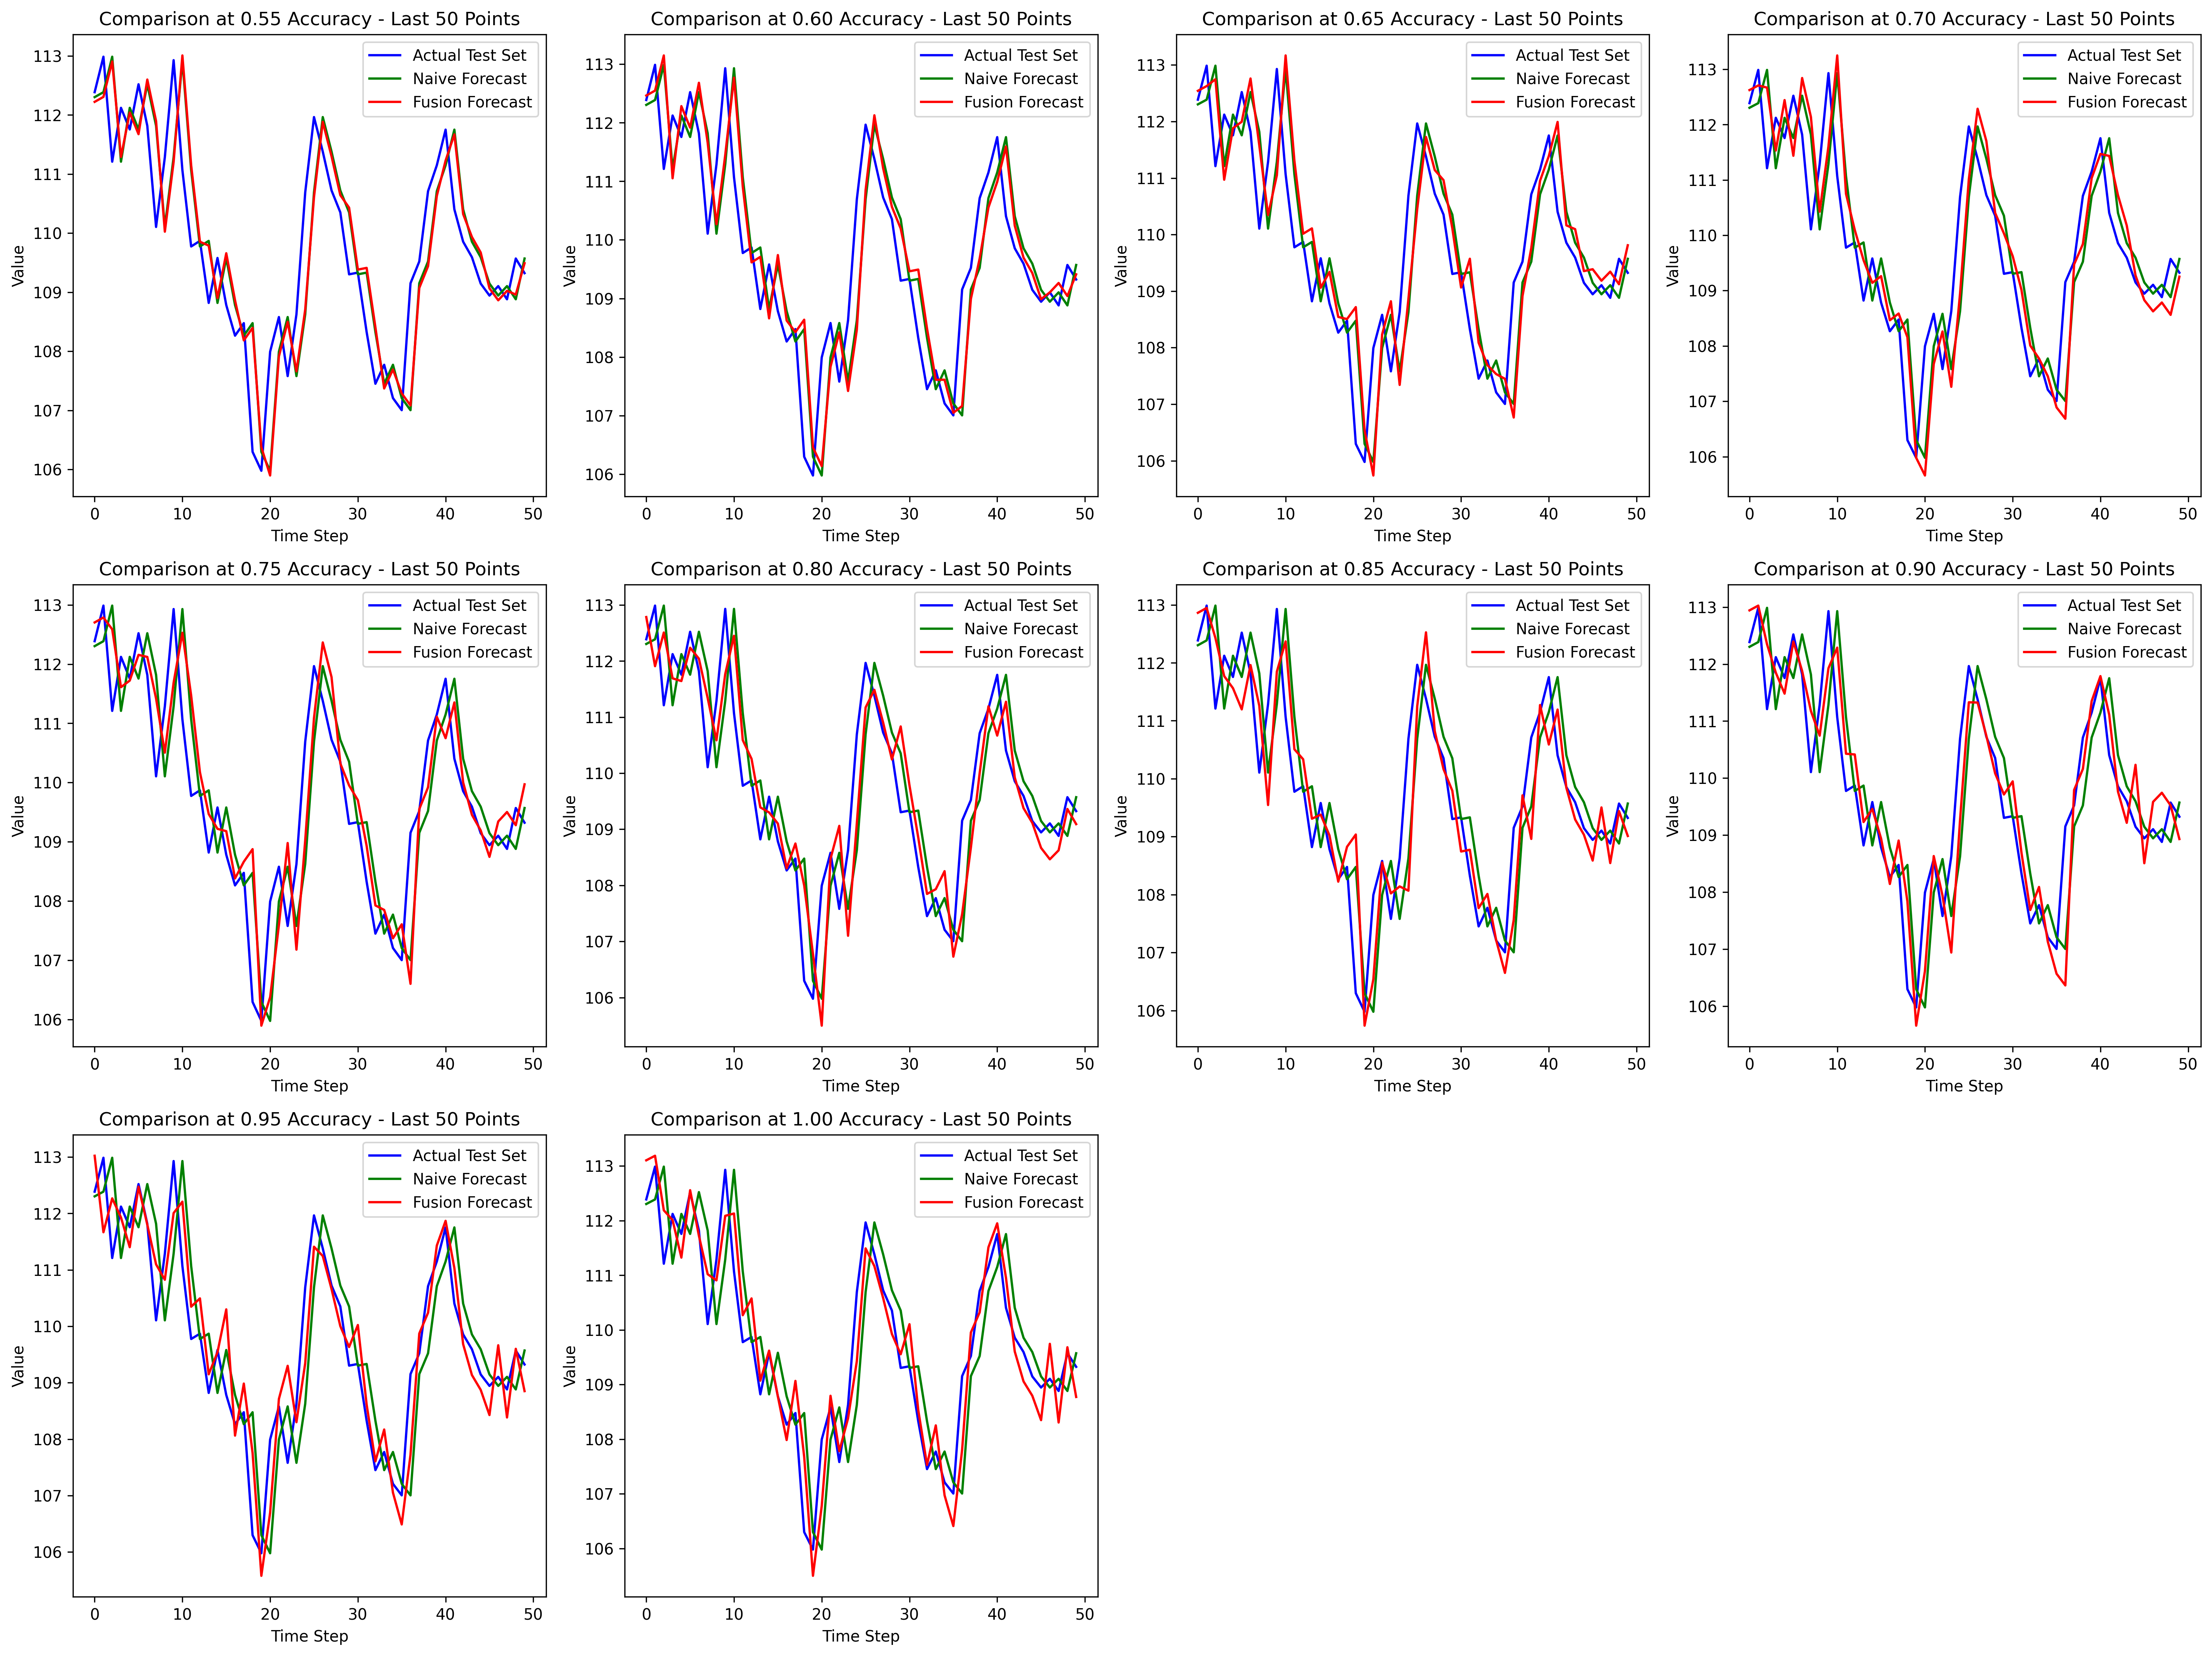

In [9]:
# Define the number of points to display from the test set
points_to_display = 50

# Setup for the figures
n_accuracies = len(results)
fig, axes = plt.subplots(3, 4, figsize=(20, 15), dpi=300)  # Adjusted for 4 columns and 3 rows

for i, (accuracy, accuracy_data) in enumerate(results.items()):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    accuracy_results = accuracy_data['trial_results']

    # Calculate the average MAE
    average_mae = np.mean([trial['mae_fusion'] for trial in accuracy_results])

    # Find the trial with the MAE closest to the average MAE
    closest_trial = min(accuracy_results, key=lambda x: abs(x['mae_fusion'] - average_mae))

    # Extract predicted movements and compute the fusion forecast
    predicted_movements = closest_trial['predicted_movements']
    weight = 2 * accuracy - 1  # Calculate weight based on accuracy

    # Calculate the fusion forecast
    fusion_forecast = naive_test + weight * mean_residual * (2 * predicted_movements - 1)

    # Select the last 50 points for plotting
    actual_last = y_test[-points_to_display:]
    naive_last = naive_test[-points_to_display:]
    fusion_last = fusion_forecast[-points_to_display:]

    # Plotting
    ax.plot(actual_last, label='Actual Test Set', color='blue')
    ax.plot(naive_last, label='Naive Forecast', color='green')
    ax.plot(fusion_last, label='Fusion Forecast', color='red')
    ax.set_title(f'Comparison at {accuracy:.2f} Accuracy - Last 50 Points')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Value')
    ax.legend()

# Adjust unused subplots
for index in range(i + 1, 12):
    fig.delaxes(axes.flatten()[index])

plt.tight_layout()
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/Simulated_random_walk_visual_Comparison.tif")
plt.show()